In [1]:
import torch
import torch.utils.data
import matplotlib.pyplot as plt

import yaml

from configs.trainer import TrainingConfig

from models.vision_encoder_decoder import VisionEncoderDecoder

from transformers import AutoTokenizer, PreTrainedTokenizer
from deeplake import load, Dataset
from torchvision.models import ViT_B_16_Weights

/Users/dinesh/miniforge3/envs/image_captioning/lib/python3.10/site-packages/pydantic/_internal/_fields.py:126: UserWarning: Field "model_str" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/dinesh/miniforge3/envs/image_captioning/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/dinesh/miniforge3/envs/image_captioning/lib/python3.10/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.6.13) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
def get_dataloader(batch_size, shuffle):
    ds: Dataset = load('hub://activeloop/flickr30k')
    val_dl = ds.query("SELECT * WHERE ROW_NUMBER() >= 27000 "). \
        pytorch(batch_size=batch_size, shuffle=shuffle, num_workers=0,
                buffer_size=32, use_local_cache=True)
    return val_dl


In [3]:
config_file = 'training_configs/local/nano.yaml'
chkpt_file = 'checkpoints/nano.pt'

In [4]:
obj = yaml.safe_load(open(config_file, 'r'))
config: TrainingConfig = TrainingConfig.parse_obj(obj)
config.model.chkpt_path = chkpt_file
print(config)

model=VisionEncoderDecoderConfig(vision_encoder_config=ViTConfig(refine_base_model=False, n_embd_out_vit=768, n_cls=16, gate_sizes=(1024,)), decoder_config=TransformerDecoderConfig(use_advanced_pos_emb=False, advanced_pos_emb_gate_sizes=None, pretrained_model=<ModelType.GPT2: 'gpt2'>, enable_gradient_checkpointing=False, n_layer=12, skip_alternate_cross_attn=True, block_size=1024, vocab_size=50257, transformer_config=TransformerConfig(rotator_config=MLPConfig(ff_mult=4.0), is_causal=False, is_cross_attn=True, max_block_size=None, is_sparse_attn=False, sparsity_factor=0.5, attn_config=SelfAttentionConfig(attn_dropout=0.1, bias=True, dropout=0.1, n_head=12, n_embd=768, attn_type=<SelfAttentionType.MULTI_HEAD: 'multi_head'>))), loose_match_decoder_state_dict=True, chkpt_path='checkpoints/nano.pt', use_cross_attn=True, use_soft_prompting=True, no_repeat_n_grams=(2, 3, 4, 5)) disable_flash=False ignore_index=-100 batch_size=4 dataloader_buffer_size=5 shuffle=True gradient_accumulation_steps

/var/folders/1n/tqgq4c0j5p7cs5dk9n284h7c0000gn/T/ipykernel_53028/3115359875.py:2: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  config: TrainingConfig = TrainingConfig.parse_obj(obj)


In [5]:
tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(config.tokenizer_str)
kwargs = {}
if tokenizer.eos_token_id is None:
    kwargs['eos_token'] = '<EOS>'
if tokenizer.mask_token_id is None and config.trainer.mask_fraction > 0:
    kwargs['mask_token'] = '<MSK>'
tokenizer: PreTrainedTokenizer = AutoTokenizer.from_pretrained(
    config.tokenizer_str, **kwargs)


In [6]:
val_dl = get_dataloader(1, False)

/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



/

hub://activeloop/flickr30k loaded successfully.



/Users/dinesh/miniforge3/envs/image_captioning/lib/python3.10/site-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['image'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [7]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.has_mps else 'cpu')

In [8]:
model = VisionEncoderDecoder(config.model).to(device)


In [9]:
model.eval()

VisionEncoderDecoder(
  (decoder): TransformerDecoder(
    (transformer): ModuleDict(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): TransformerBlock(
          (ln_1): LayerNorm()
          (attn): MultiHeadAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): _MLP(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (cross_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuan

In [13]:
# num_beams = 4
# num_new_tokens = 64
# top_k = 16
# temperature = 1.0
# consolidation_temperature = 100.0
# batch_size = 1
ignore_index = -100
# beam_expansion_factor = 8
# length_boost = 1.0

num_candidates = 8

In [14]:
# generator = BeamSearchTokenGenerator(
#     model,
#     beam_width=num_beams,
#     temperature=temperature,
#     consolidation_temperature=consolidation_temperature,
#     max_new_tokens=num_new_tokens,
#     no_repeat_n_grams=(2, 3, 4, 5),
#     top_k=top_k,
#     beam_expansion_factor=beam_expansion_factor,
#     eos_token_id=tokenizer.eos_token_id,
#     length_boost=length_boost,
# )

/var/folders/1n/tqgq4c0j5p7cs5dk9n284h7c0000gn/T/ipykernel_53028/1971700734.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'])


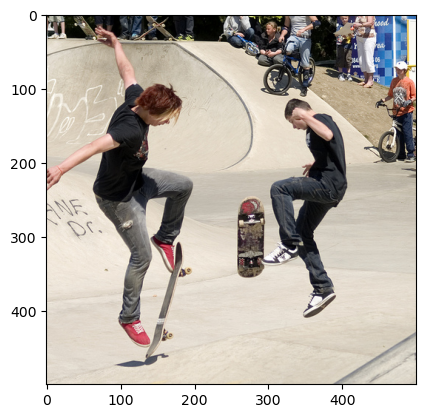

truth The teenage boys in black shirts skateboarding in a skate park , surrounded by people . Two teen guys are doing skateboard tricks at a skate park . Two kids in jeans perform skateboard tricks . Two guys are in the air while skateboarding . Two teenagers doing tricks on skateboards . 

A skateboarder doing tricks while playing the skate on skateboards.
A man in shorts and a skateboard jumps over a railing.
A skateboarder performs a jump on the street.
A skateboarder in black boots performs a trick on a skate park.
A skateboarder who has not ridden on a bike.
A skateboarder with a yellow hat and a blue shirt is performing a trick on a skate ramp.
A skateboarder with a skateboarding toy jumps to the side.
A man skateboarding on a skateboard.


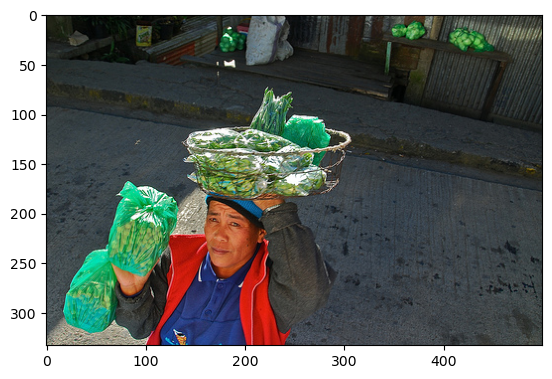

truth A man walked across a street holding a basket on top of his head filled with fruit and vegetables with one hand , while holding bags of grapes in his right hand . A man carrying bags of vegetables in one hand and a tray of vegetables in the other . this man is works harder than most people in the world . A man holding asparagus in a basket over his head . A man is holding a basket above his head . 

A man sits at the side of a fruit stand.
A man in a striped shirt and blue shorts holds a large bag of bananas in front of several green plants.
A man in a blue shirt, wearing a hat and sunglasses in front of a shopping cart.
A man in a jacket and a pink dress stands in front of a cart on a busy street.
A man holding a bag is carrying an umbrella with his hands.
A man wearing a gray coat stands outside with a basket.
A young African man in a striped shirt is buying bread outdoors.
A man selling food.


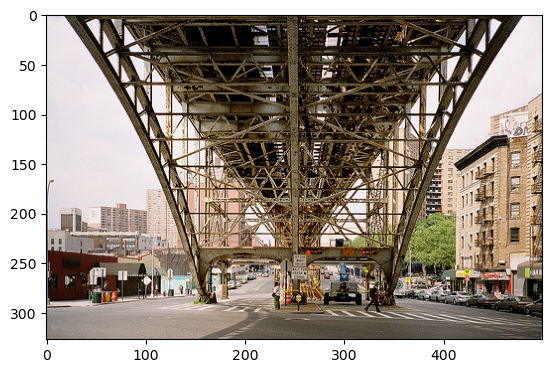

truth Large bridge-like structure built on a road between tall buildings within the city . People walk across the street under a bridge . People using crosswalk on big city street . A man is walking under a bridge . The bottom view of a bridge . 

A man and a woman walk by a bridge.
A man in the city of Lima is looking at a bridge in front of the railroad station.
A man in a white jacket works on a railroad bridge.
A man wearing a white shirt with blue stripes and an orange helmet rides a bridge near the bridge.
A man walking by two people working in the railroad.
A woman in a white dress reading a book on the train tracks with a black sign on.
A large building is visible in the background.
A worker in white sweatshirts walks past an industrial sign.


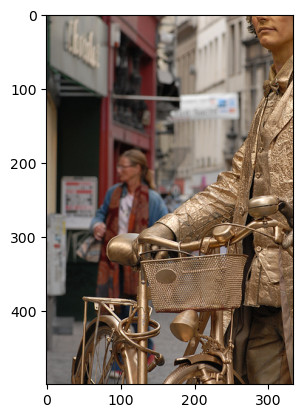

truth In the middle of a shopping center , there is a man who is painted gold with a gold bicycle . A man dressed in gold with his gold bike stops to look at the city . A man is wearing a gold outfit while standing with his gold bike . A man painted in gold with cycle stands in the street . A man in a gold coat has a gold bicycle in the city . 

A man is wearing a hat and boots on a streetcar.
A man wearing a hat is sitting on a bench with a book of horse.
A man is riding a bike with his back to the camera in front of him.
A man in an orange suit is holding a newspaper.
A man holding a sign reading " B.S."
A man rides a bike in a park with some trees.
A man is standing on a metal bench.
A man with a hat on a bike sits on the sidewalk waiting for a ride.


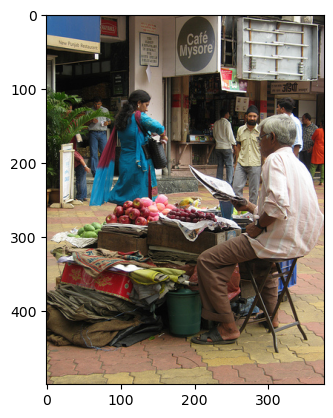

truth A man with gray hair is sitting on a stool reading a newspaper in a market type setting . An elderly outdoor market vegetable vendor sits with his wares and reads a newspaper . A man in a white shirt reads while waiting to sell fruit . A man in reads the newspaper and sells his produce . a man reads his newspaper while selling fruit . 

A middle-aged man is selling fruit and a small basket.
A man wearing glasses and a hat is shopping in a market.
A man in an orange t-shirt and shorts is selling food.
A man in a black shirt is selling food.
A woman with brown hair and a blue shirt, looking at a fruit stand, while walking past a large market.
A group of people sit in a grocery store and read a book with a paper print.
A man wearing a gray coat is selling items, while a woman in a black shirt is sitting in the back of the store.
A man in a black shirt and jeans walks down the street with a basket of beans and a small assortment of vegetables.


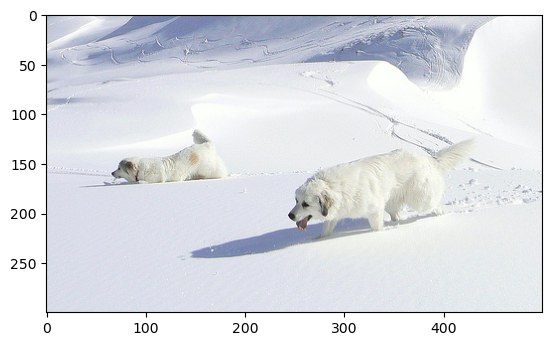

truth Two white dogs walk through a huge bank of mountain snow . Two white dogs are walking through deep white snow . Two fluffy white dogs are in the snow . Two white dogs walk in a snowy setting Two white dogs walking in the snow . 

A dog runs next to a large snow.
A dog running along the snow covered mountains
A dog is standing in the snow.
A white dog playing in the snow
A black dog runs through its snow.
A dog in snow.
A dog runs down muddy hillside with snow on its back.
A small brown dog is running in the snow.


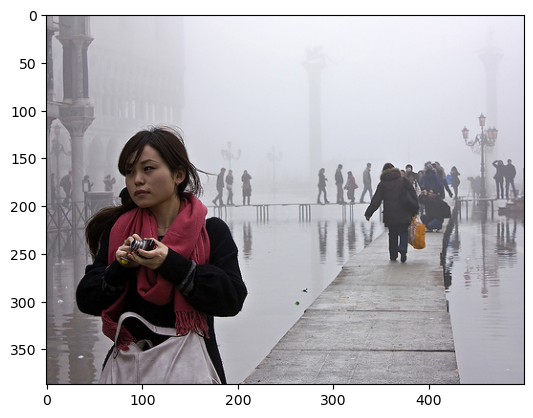

truth A woman is thinking of what she wants to capture with her camera , while people are walking on the boardwalk . A woman with a camera as many people behind her walk across the water on a walkway . An Asian women , with a burgundy scarf , moves through a misty city . An Asian woman is holding a camera in a foggy day . A woman with a camera on a foggy day . 

A man in a white shirt looking at water
A woman is walking around.
A woman in a white jacket and blue jeans is walking in front of a fountain that is painted with the words 'LONDON '.
A woman in a pink dress is standing outside with a camera.
A man sitting on a railing looking at the sun.
A woman dressed in a white sweater sitting on a sidewalk in front of a black umbrella.
A woman sitting outside an outdoor restaurant.
A woman in a black jacket with a red umbrella is wearing an orange turtleneck sweater.


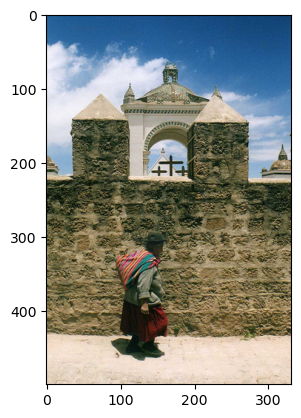

truth A woman in a fedora with a striped knapsack is walking in front of a brick wall , crosses , and an arch . A woman with a colorful bag and a red skirt stands by a wall at the edge of a church . A woman wearing a red skirt is walking beside a stone wall . An old lady with a red skirt and hat is walking in the sun . A traveler is walking down a road . 

A man in a hat is standing on a statue surrounded by two people in white robes and a man and one man walking on stone steps.
A man in a green robe walking by a wall of stones.
A boy dressed in black and white is standing beside the statue of the city.
A man dressed in black is walking along a pathway leading to a statue.
A man standing on a stone wall looking at a statue in front of an old stone structure.
A man on a walkway is carrying something off of a stone wall.
A man wearing a hat walking by a monument.
A man is walking past an old building.


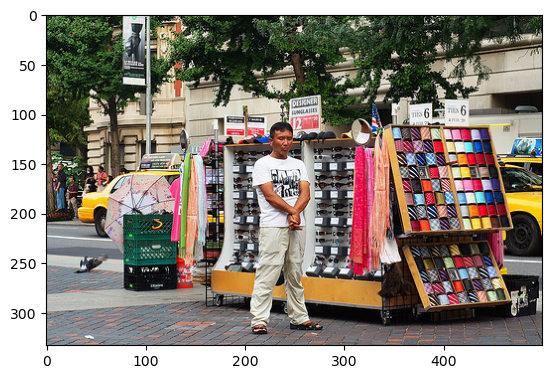

truth A man stands in front of a street vending booth with his hands crossed awkwardly in front of him while two yellow taxis are seen in the background of the cityscape . A street vendor that sells ties and sunglasses is standing with his hands together looking at the camera . A main in a white shirt and tan pants stands in front of a stand that sells various goods . A man is standing in front of a street stand with folded hands . A man with a white shirt standing next to a vending stall . 

A man in sunglasses and brown shirt is looking at a large sign of a shopping center.
A man wearing a yellow sweatshirt and jeans carries a white cart on a sidewalk.
A man in a dark suit sits on an sidewalk, looking out at the city.
A man walking outside a store.
A man wearing a hat walking around on a sidewalk.
A man in jeans and jeans walking behind two yellow signs.
A man sits on some sidewalk with a bag.
A man in an umbrella stands next to an orange flag with the words " UNITED STATES UNITED UN

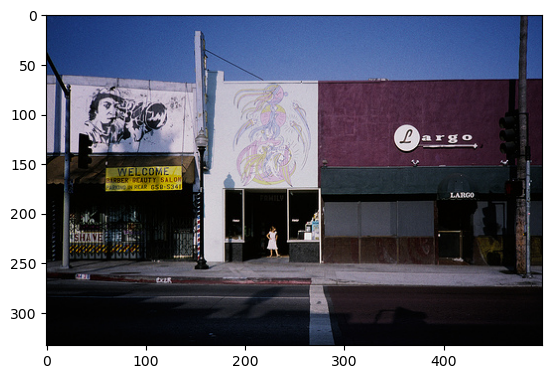

truth A woman is wearing a white dress in a store that has some decals on the outside , and is in the middle of two other stores , one that says welcome , and one that 's called Largo . A woman is standing near three stores , two have beautiful artwork and the other store has Largo written on it . A little girl with a white dress is standing under the doorway of a store . A storefront with poor artist rendition of street art . A girl is standing in a store next to other stores . 

A man, dressed in a red shirt, sits in front of yellow signs and the signs in the background with a sign in white and purple.
A group of people sit down next to a large sign that reads'"'s Welcome to your home.
A street artist and a woman looking into a mirror.
A couple is walking down a busy street with signs.
A man in a black t-shirt, holding a sign.
A man sits on a balcony at a city square.
A man in jeans, a gray sweatshirt.
A man sits on top of an advertisement billboard with a sign reading " People and M

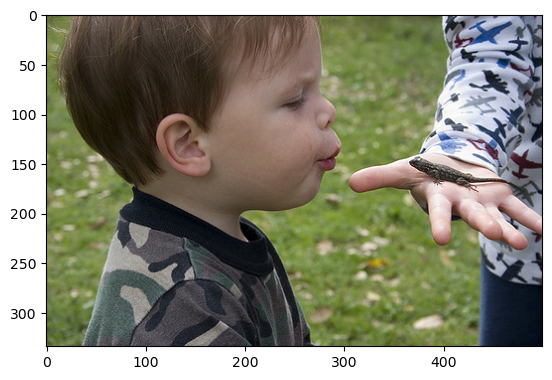

truth A little boy puckers up as to kiss a little lizard being held by another young child . A little boy is looking at a lizard which is in someone else 's hand . Cute little boy in an army shirt blowing a kiss at a small lizard . A child looks at a lizard in another child 's hand . Little boy is giving a kiss to a lizard . 

A young girl in a pink shirt has her thumb on her cheek.
A little boy in a green shirt, smiling, holds his hands in front of his mouth.
A little girl with dark hair is playing with a stick.
A little boy in a green top hat and purple shorts holds a black stick in his mouth.
A young boy with a pink shirt, wearing a shirt and jeans, is holding a camera.
A man in a green shirt looks down while a little brown dog holds on a leash.
A man wearing a shirt is walking by water.
A little brown girl in a green striped shirt, in the mud.


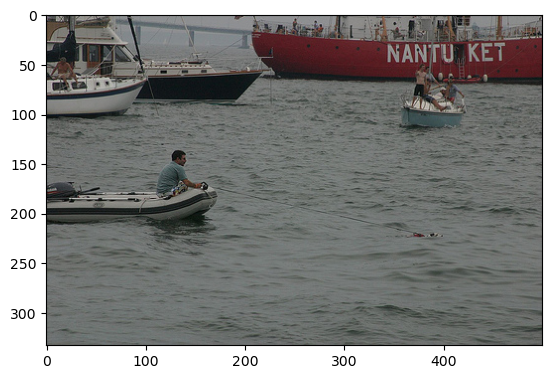

truth This simple fisherman reels in his anchor so he can start to go home as it is about to start raining judging from the overcast . A man is holding on to a piece of rope , sitting in an inflatable boat , in front of several other larger boats . Fishermen out fishing in boats , and a dog swimming in the water . A number of boats of varying sizes are cruising in a semi-circle . A man tugs on a rope in a harbor . 

A person in kayak on a dock at sunset.
A man in green jeans is standing by a canal on the side of a boat that seems to be floating down below the water.
A man in a gray jacket is riding a yacht with a group of people in it.
A group of people are enjoying the shoreline of a lake and looking down at the water.
A man and woman are fishing near the edge of the lake.
A man wearing orange and white is standing on the edge of a boat in the water while the boat is being towed by.
A man rides a boat through the water.
A man on a boat looking through the water.


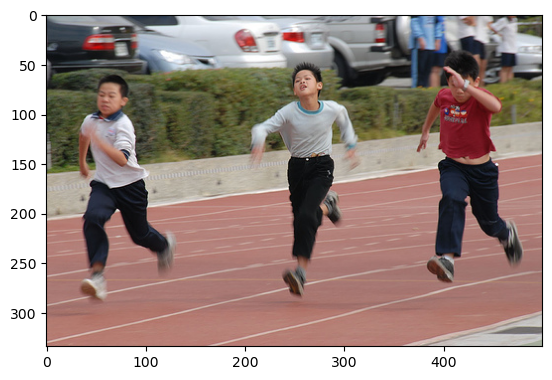

truth Three young boys wearing dark colored pants are running on a track . Three boys racing against each other on the track . Three boys are racing against each other . Three Asian boys race each other 3 kids running on a red track . 

A girl jumping to jump with a yellow flag on her back.
A woman in an orange and black shirt is jumping from high rope.
A young girl in a black t-shirt and black jacket is jumping over a fence.
A girl jumps over the bridge with three people around her.
A woman wearing a black backpack is jumping in the air while two boys in orange outfits and white sneakers watch.
A girl is running on a track with two other girls.
A woman leaps over a wall as a man looks on.
A young lady jumps off a bridge into the distance.


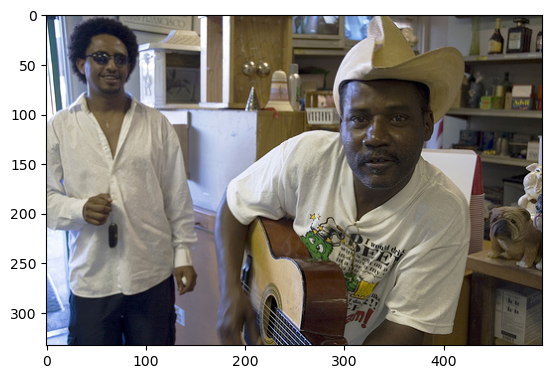

truth Two African Americans are together and one is wearing a cowboy hat while playing the guitar while the other is standing with sunglasses on . A dark-skinned man in a straw hat playing guitar and a man in sunglasses listening and smiling . Two African American males looking into the camera while their photo is taken . An African american man wearing a cowboy hat playing the guitar . A black man plays guitar while another man watches . 

A man is standing in front of a statue in a restaurant.
A man is holding a picture of a man in suit.
A man is holding a white book and a book with a man and white hat.
A man holding a microphone.
A man is wearing a blue hat, wearing his hands and his knees.
A young man wearing a beard and a cowboy hat is sitting in an old white chair, and one man is standing in front of him.
A man wearing sunglasses and cowboy boots is holding a microphone.
A man wearing a beard standing behind a man who has a tattoo on his back.


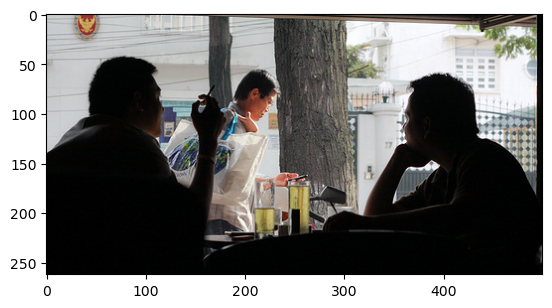

truth Two men are sitting at a table , one of them smoking , with two drinks on their table staring out into the area in front of them . Two men inside having a drink while one smokes as they watch another man walking just outside . two men are sitting down at a table with drinks looking out at another man walking with a bag . Two people are at a table with drinks . Two men are conversing in a diner . 

A young boy eating sandwiches on the corner of a cafe.
A man sits behind a table with beer cans.
A man and a girl eating.
A smiling man eating a meal near the sidewalk.
A man is drinking coffee.
A man with a black shirt and brown shirt reads a newspaper.
A man with a mustache is talking to another man wearing glasses.
A young man in a white shirt reads the newspaper.


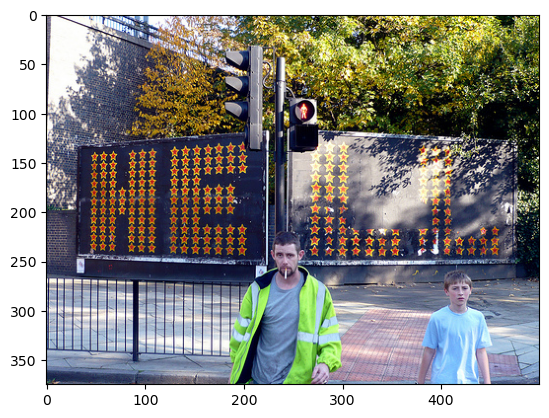

truth Two young men , one smoking , walk past a large sign that uses orange stars to spell " HELL " . Two people stand next to a sign that says " HELL " made out of stars . Two males on a street corner crooswalk with a billboard behind them . A man and a boy standing in front of a sign that says " HELL " . Two males stand by a board that says HELL . 

A man and a woman wearing orange jeans walk past the entrance.
A man and woman walking down the sidewalk at a street festival.
A man and two women are walking past a sign that reads " " man is wearing his orange shirt, ", and " woman is holding a blue hat.
A woman in a yellow shirt talks to a man in black shirt.
A man is walking through a street.
A man in yellow and white shirt talking and walking in the street.
A man on a cellphone talking on his cellphone while others walk by.
A man standing on a curb with a white sign.


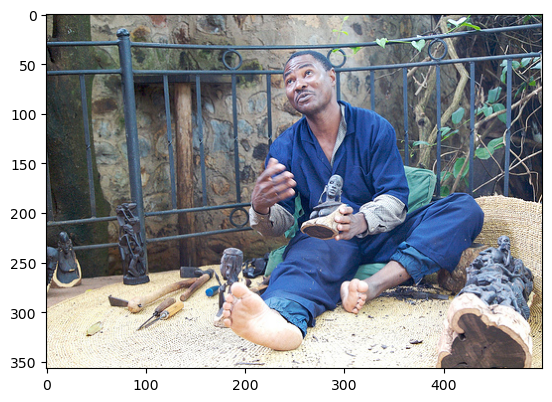

truth A man sitting in sand holding a small statue carved of wood . A man in a blue jumpsuit showing the carvings he has made . A man in a blue jumpsuit displays his sculptures . A black man is making wood carvings . A man is showing some mini sculptures 

A man in a black shirt has been hanging up on a wall.
A man is wearing a red t-shirt as he sits at a rock climbing pole.
A man is cutting down a tree branch of a wooded area.
A woman and a woman are kneeling in front of something that is carved with a man.
A group of men are standing on a stone pillar.
A man wearing a brown robe and white gloves with black and black hair is kneeling to an altar.
A man in a black and white dress standing by the rocks with a large fish.
A man with long curly hair, playing with a hammer.


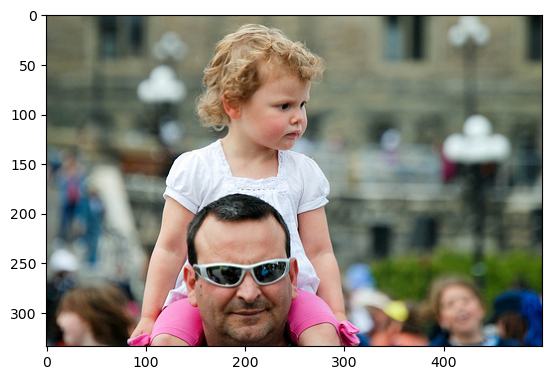

truth A cute curly headed little girl sitting on a man 's shoulders . A little girl with pink pants sits on a man 's shoulders . A man is carrying a little girl on his shoulders . A little girl riding on a man 's shoulders . A young girl sits on a man 's shoulders . 

A person holding a camera.
A young adult with long black hair, wearing sunglasses, and a hat.
A man is looking at a picture.
A man in a black shirt is smiling.
A man and woman in a blue shirt and a white jacket are smiling as a man holds them.
A little girl wearing a jacket.
A kid with blond-hair looks like he has taken a picture.
A boy is hugging another girl.


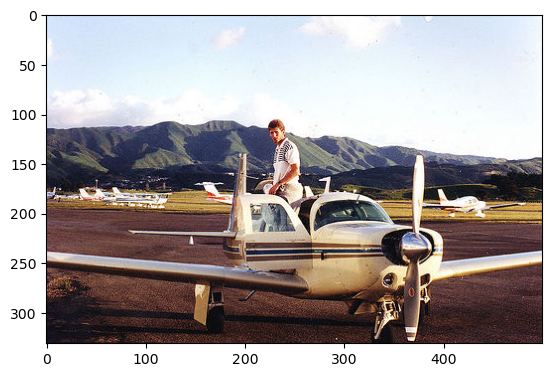

truth A man in a white shirt is standing outside of the door of a small airplane with mountains in the background . A man standing in the door of a plane wearing a white short-sleeved shirt with stripes . A man in a white shirt is standing on an airplane . A man in standing in the doorway of a small plane . A man stands inside of a small plane . 

A blond-haired man in cowboy hat and a black hat sits in front of a large green screen.
A man sitting in a boat, with a white flag and a green light.
A man in a green jacket is standing at a picnic while looking at his laptop.
A man on a black boat is pointing with his thumb up at his camera.
A man sits on a plane and looks out into the sky at a red car.
A man in a black shirt is watching an airline flight from the United States.
A man in a black shirt walks with two guns while sitting at a picnic tables and drinking tea.
A man stands outside the ocean, with a white hat as he is pointing out.


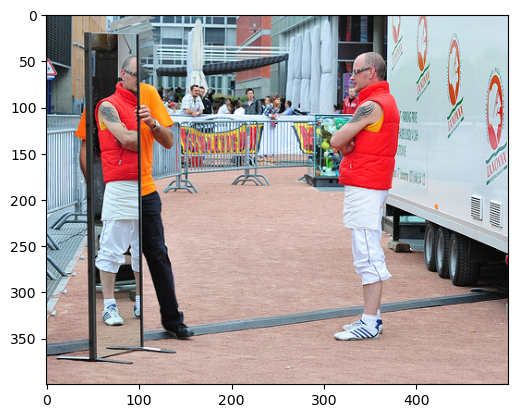

truth A man with an orange vest and a tattoo on his left arm is standing in front of a mirror where they are setting up for some kind of show . A man with a red vest looking at a man with an orange shirt holding a mirror . A man in white pants and a bright orange vest is admiring his reflection . A man in a red coat is looking at himself in a mirror outside . A man in an orange vest looking at his reflection in a mirror . 

A man in black shirt is talking to another man, while two others watch.
A group sitting in a busy street.
A man in a white shirt with a blue shirt is sitting around outside a large sign that reads " " People and their Children ", and the boy in the blue shorts is talking to a woman that is holding a green umbrella and a yellow and white umbrella.
A male man sitting on the outside looking towards the crowd.
A group of people standing with a yellow sign in front of a building.
A man in sunglasses, holding a sign with yellow bars, stands with several people waiting out

In [18]:
tx = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms()


for i, batch in enumerate(val_dl):
    if i == 20:
        break

    x = torch.tensor(batch['image'])
    plt.imshow(x[0])
    plt.show()

    x = tx(x[0].permute(2, 0, 1)).unsqueeze(0)

    prompt = 'A'
    prompt_ids = torch.tensor(tokenizer(text=prompt).input_ids, dtype=torch.long).to(x.device).unsqueeze(0).expand(x.size(0), -1).contiguous()
    x = x.to(device).expand(num_candidates, -1, -1, -1)

    decoded_ids = torch.tensor(
        tokenizer(text=prompt).input_ids,
        dtype=torch.long).to(device).unsqueeze(0).expand(x.size(0), -1).contiguous()

    result = model.generate(images=x,
                            prompt_ids=decoded_ids,
                            temperature=1.0,
                            max_new_tokens=64,
                            top_k=16)
    result = tokenizer.batch_decode(result)

    print('truth', batch['caption_0'][0], batch['caption_1'][0], batch['caption_2'][0], batch['caption_3'][0], batch['caption_4'][0], '\n')
    for gen in result:
        i = gen.find(tokenizer.eos_token)
        gen = gen[:i]
        print(gen)
    print("========================================================")